In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import os
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [2]:
data_path = '../brain-tumor/'

In [3]:
def main(train_data_path):

    
    for dirs in [train_data_path]:

        filepaths = []
        labels = []
        classes_list = sorted(os.listdir(dirs))

        filepaths,labels = get_fileList(classes_list, dirs, filepaths, labels)
        
        train_df = obtain_train_df(filepaths, labels)
        
            
    return train_df



def get_fileList(classes_list, dirs, filepaths, labels):
 
    
    
    for s_class in classes_list:
        
        label = s_class
        classpath = os.path.join(dirs, s_class)
        flist = sorted(os.listdir(classpath))
        
        store_image_names_and_its_labels(flist, classpath, filepaths, labels, label)
        
    return filepaths, labels


def store_image_names_and_its_labels(flist, classpath, filepaths, labels, label):
    
 
    
    for file in flist:
        file_path = os.path.join(classpath, file)
        filepaths.append(file_path)
        labels.append(label)



def obtain_train_df(filepaths, labels):

    
    train_df =pd.DataFrame({
        'image_path' : filepaths,
        'label' : labels
    })
    return train_df

In [4]:
data_df = main(data_path)

In [7]:
test_split_size = 0.3
train_df, test_df = train_test_split(data_df, test_size=test_split_size, shuffle=True, random_state=123, stratify=data_df['label'])
test_df, valid_df = train_test_split(test_df, test_size=0.5, shuffle=True, random_state=123, stratify=test_df['label'])

In [11]:
img_size = (224, 224)
channels = 3
color = 'rgb'
img_shape = (img_size[0], img_size[1], channels)
batch_size = 32
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
def scalar(img):
    return img

In [12]:
tr_gen = ImageDataGenerator(preprocessing_function= scalar, 
                            horizontal_flip= True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, 
                                       x_col= 'image_path', 
                                       y_col= 'label', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= color, 
                                       shuffle= True, 
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, 
                                       x_col= 'image_path', 
                                       y_col= 'label', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= color, 
                                       shuffle= True, 
                                       batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, 
                                      x_col= 'image_path', 
                                      y_col= 'label', 
                                      target_size= img_size, 
                                      class_mode= 'categorical',
                                      color_mode= color, 
                                      shuffle= False, 
                                      batch_size= test_batch_size)


Found 3134 validated image filenames belonging to 44 classes.


/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  "These filename(s) will be ignored.".format(n_invalid, x_col)


Found 672 validated image filenames belonging to 44 classes.
Found 672 validated image filenames belonging to 44 classes.


In [13]:
class_count = len(list(train_gen.class_indices.keys())) 

In [14]:
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, 
                                                               weights= "imagenet", 
                                                               input_shape= img_shape,
                                                               pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

115263384/115263384 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 44)                11308     
                                                                 
Total params: 29,057,571
Trainable params: 28,880,732
N

In [15]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5,
                           verbose=1)

checkpoint = ModelCheckpoint('model_weights.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=1)


history = model.fit(x= train_gen, 
                    epochs= 200, 
                    callbacks=[early_stop, checkpoint],
                    validation_data= valid_gen)

Epoch 1/200


2024-10-10 04:10:50.378931: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb5/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


98/98 [==============================] - ETA: 0s - loss: 10.0494 - accuracy: 0.3848
Epoch 1: val_loss improved from inf to 9.17470, saving model to model_weights.h5
98/98 [==============================] - 218s 1s/step - loss: 10.0494 - accuracy: 0.3848 - val_loss: 9.1747 - val_accuracy: 0.3810
Epoch 2/200
98/98 [==============================] - ETA: 0s - loss: 7.3821 - accuracy: 0.7007
Epoch 2: val_loss improved from 9.17470 to 7.03009, saving model to model_weights.h5
98/98 [==============================] - 93s 949ms/step - loss: 7.3821 - accuracy: 0.7007 - val_loss: 7.0301 - val_accuracy: 0.6086
Epoch 3/200
98/98 [==============================] - ETA: 0s - loss: 5.8368 - accuracy: 0.8389
Epoch 3: val_loss improved from 7.03009 to 5.71315, saving model to model_weights.h5
98/98 [==============================] - 93s 947ms/step - loss: 5.8368 - accuracy: 0.8389 - val_loss: 5.7132 - val_accuracy: 0.7366
Epoch 4/200
98/98 [==============================] - ETA: 0s - loss: 4.7051 - ac

In [16]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

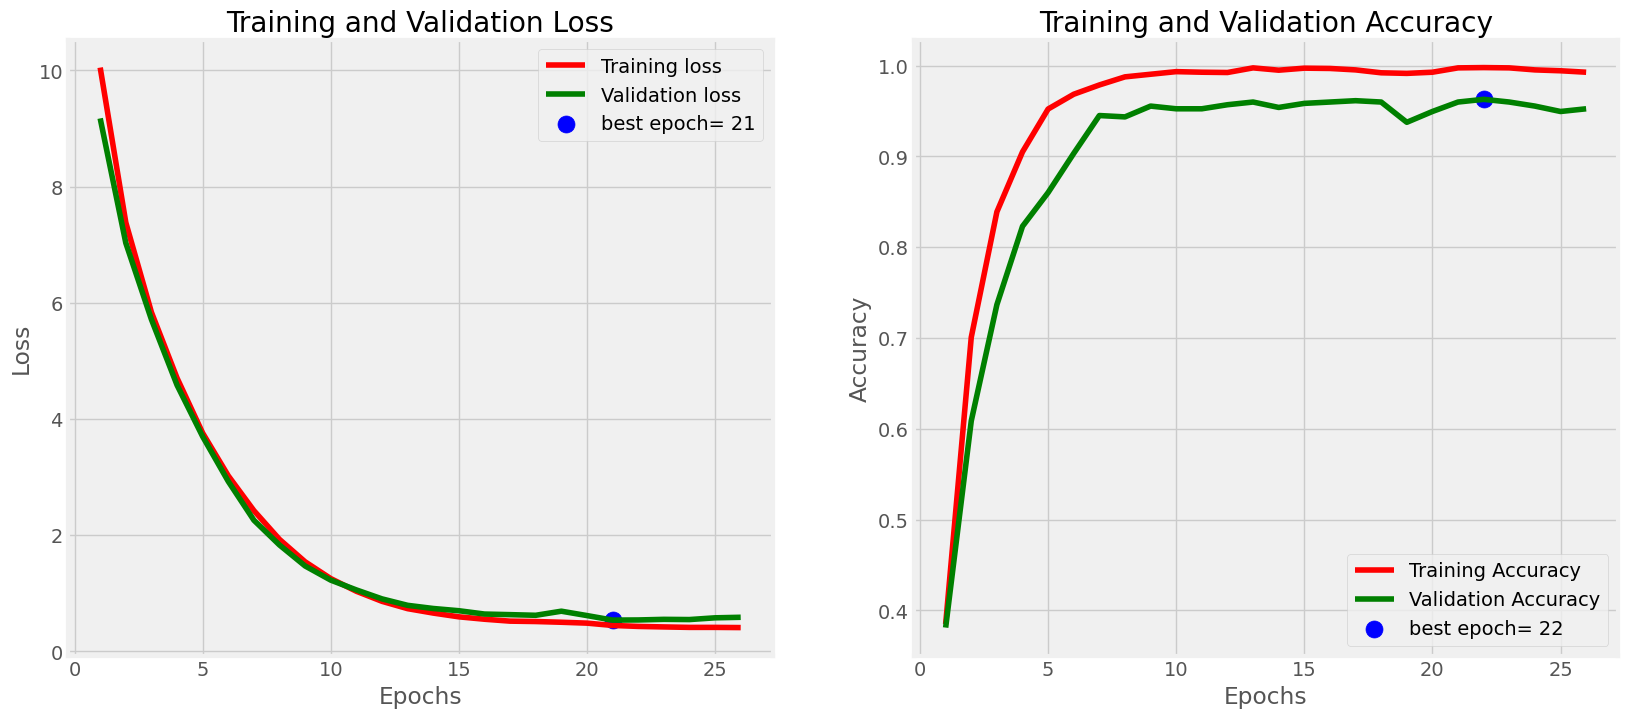

In [17]:
plot_training(history)

In [18]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

12/12 [==============================] - 8s 510ms/step - loss: 0.7025 - accuracy: 0.9286
Train Loss:  0.3604755699634552
Train Accuracy:  0.9947916865348816
--------------------
Validation Loss:  0.5474340319633484
Validation Accuracy:  0.9583333134651184
--------------------
Test Loss:  0.7024935483932495
Test Accuracy:  0.9285714030265808


In [19]:
y_pred = model.predict(test_gen)

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = test_gen.classes

12/12 [==============================] - 8s 358ms/step


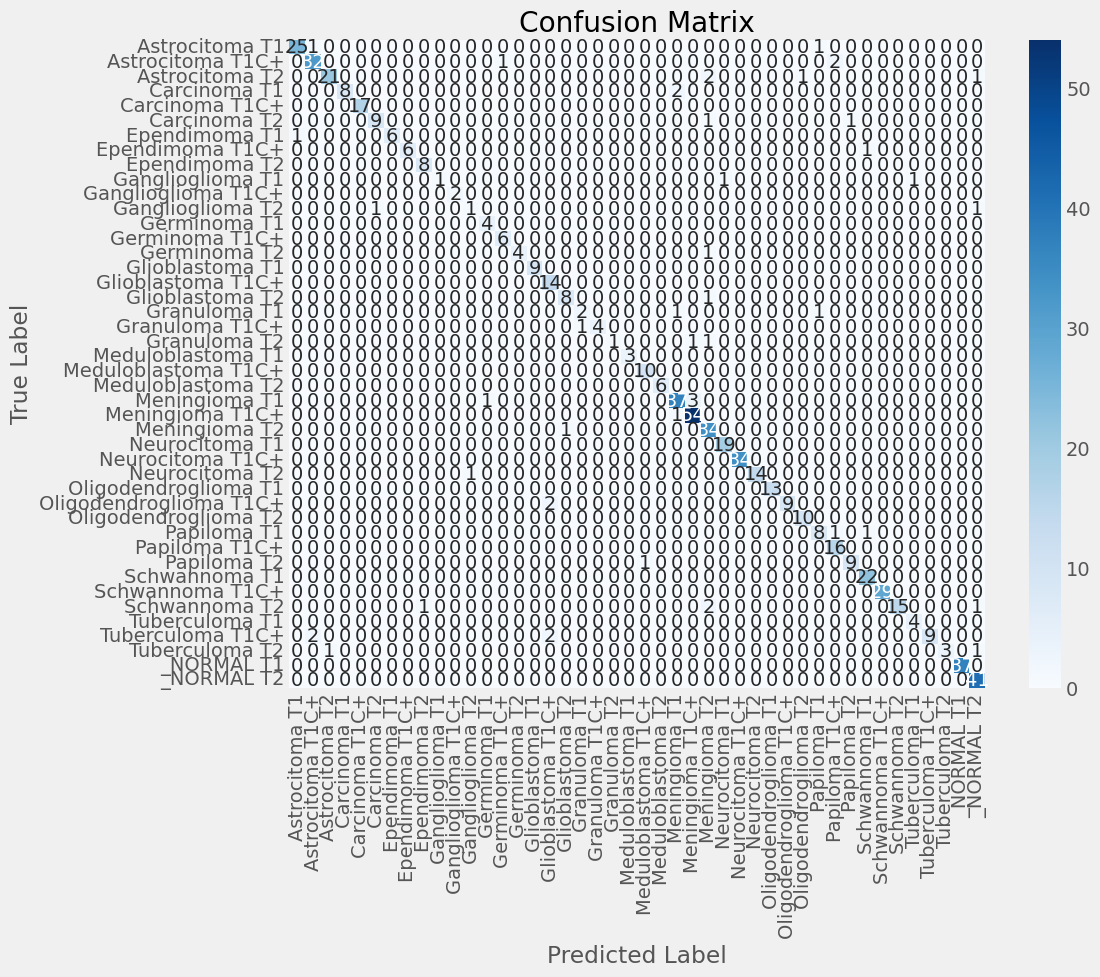

In [20]:
class_names = list(test_gen.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [21]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

print("Classification Report: ")
print(report)

Classification Report: 
                        precision    recall  f1-score   support

        Astrocitoma T1       0.96      0.93      0.94        27
      Astrocitoma T1C+       0.91      0.91      0.91        35
        Astrocitoma T2       0.95      0.84      0.89        25
          Carcinoma T1       1.00      0.80      0.89        10
        Carcinoma T1C+       1.00      1.00      1.00        17
          Carcinoma T2       0.90      0.82      0.86        11
         Ependimoma T1       1.00      0.86      0.92         7
       Ependimoma T1C+       1.00      0.86      0.92         7
         Ependimoma T2       0.89      1.00      0.94         8
      Ganglioglioma T1       1.00      0.33      0.50         3
    Ganglioglioma T1C+       1.00      1.00      1.00         2
      Ganglioglioma T2       0.50      0.33      0.40         3
          Germinoma T1       0.80      1.00      0.89         4
        Germinoma T1C+       0.86      1.00      0.92         6
          Germi